In [140]:
%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

rcParams['figure.figsize'] = 8, 5
plt.style.use('seaborn')

df = pd.read_csv('../out.csv')

# exclude everything with a price above or below 3 standard deviations (i.e. outliers)
df = df[np.abs(df['price_per_meter'] - df['price_per_meter'].mean()) <= (3 * df['price_per_meter'].std())]

# one-hot for category labels (the energy_label and building_type columns only for now)
df = pd.concat([df, 
                pd.get_dummies(df['energy_label'], prefix="energy_label"),
                pd.get_dummies(df['building_type'], prefix="building_type")], axis=1)

# dropping 
df.drop(columns=['funda_id', 'address', 'price_per_meter', 'zipcode', 'city', 'url', 'energy_label', 'building_type', 'listed_since', 'date_of_sale'], axis=1, inplace=True)

# dropping fields I postponed processing so far
df.drop(columns=['insulation', 'estate_type'], axis=1, inplace=True)

# splitting the dataset
y = df.price
x = df.drop(columns=['price'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [125]:
# random forest grid cv training
forest = RandomForestRegressor(n_jobs=-1, random_state=0)
forest_params = {'n_estimators': range(1, 150, 10), 'max_depth': list(range(1, 20)) + [None], 'max_features': range(10, 25) }
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
forest_grid.fit(x_train, y_train)

Fitting 5 folds for each of 4500 candidates, totalling 22500 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 78.7min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 94.9min
[Parallel(n_jobs=-1)]: Done 11246 tasks      | elapsed: 113.8min
[Parallel(n_jobs=-1)]: Done 12796 tasks      | elapsed: 1

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141], 'max_features': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [139]:
# random foret results
print("Best score:", forest_grid.best_score_)
print("Best params:", forest_grid.best_params_)

('Best score:', 0.8744477622200465)
('Best params:', {'max_features': 14, 'n_estimators': 121, 'max_depth': 17})


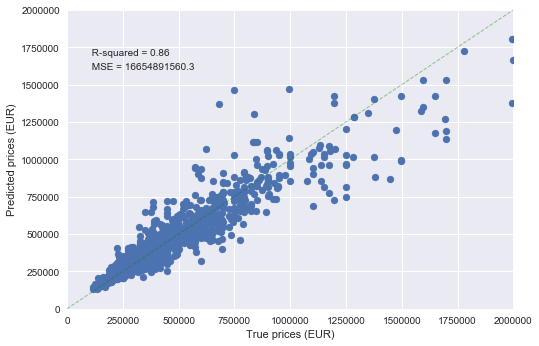

In [143]:
# best parameters forest
forest = RandomForestRegressor(n_estimators=121, max_features=14, max_depth=17, n_jobs=-1, random_state=0)
forest.fit(x_train, y_train)
forest_predicted = forest.predict(x_test)

# plotting
plt.scatter(y_test.reset_index(drop=True), pd.Series(forest_predicted).astype('int'))
plt.plot([0, 2000000], [0, 2000000], "g--", lw=1, alpha=0.4)
plt.xlabel("True prices (EUR)")
plt.ylabel("Predicted prices (EUR)")
plt.text(100000, 1700000, ' R-squared = {}'.format(round(float(forest.score(x_test, y_test)), 2)))
plt.text(100000, 1600000, ' MSE = {}'.format(round(float(mean_squared_error(y_test, forest_predicted)), 2)))
plt.axis([0, 2000000, 0, 2000000])
plt.show()